# HW06

Что делаем по требованиям:
- Загружаем выбранный CSV (путь относительный), делаем базовый EDA и проверяем баланс классов.
- Формируем X/y (исключаем `id` из признаков).
- Train/test split с фиксированным `random_state` и `stratify`.
- Baseline: DummyClassifier + LogisticRegression (Pipeline).
- Модели недели 6: DecisionTree + RandomForest + Boosting (HistGradientBoosting).
- Подбор гиперпараметров: **только на train через CV**.
- Финальная оценка: один раз на test, единые метрики (accuracy, F1, ROC-AUC; для дисбаланса ещё PR/Average Precision).
- Диагностические графики: минимум 2 (confusion matrix + ROC/PR).
- Интерпретация лучшей модели: permutation importance (top-10/15).
- Сохранение артефактов в `artifacts/`.

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

from sklearn.inspection import permutation_importance
import joblib
import sklearn

# Настройки эксперимента
RANDOM_STATE = 42
TEST_SIZE = 0.25

DATASET_FILENAME = "S06-hw-dataset-04.csv"
DATA_PATH = Path(DATASET_FILENAME)

ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("sklearn:", sklearn.__version__)
print("cwd:", Path.cwd().resolve())
print("data:", DATA_PATH.resolve())
print("artifacts:", ARTIFACTS_DIR.resolve())

sklearn: 1.8.0
cwd: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06
data: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\S06-hw-dataset-04.csv
artifacts: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts


In [2]:
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Не найден файл {DATA_PATH}. Положи CSV рядом с HW06.ipynb (в homeworks/HW06/) "
        "или исправь DATASET_FILENAME."
    )

df = pd.read_csv(DATA_PATH)

display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


Shape: (25000, 62)
Columns: ['id', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'target']


In [3]:
print("Info:")
df.info()

print("\nDescribe (numeric):")
display(df.describe().T)

print("\nMissing values (top-15):")
display(df.isna().sum().sort_values(ascending=False).head(15))

if "target" not in df.columns:
    raise ValueError("В датасете нет колонки 'target'.")

print("\nTarget distribution (counts):")
display(df["target"].value_counts(dropna=False))

print("\nTarget distribution (share):")
display((df["target"].value_counts(normalize=True, dropna=False) * 100).round(3))

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float

,count,mean,std,min,25%,50%,75%,max
id,25000.0,12500.500000,7217.022701,1.000000,6250.750000,12500.500000,18750.250000,25000.000000
f01,25000.0,-0.000386,1.001623,-4.370993,-0.680165,0.001859,0.679702,4.208888
f02,25000.0,-0.004872,0.995606,-4.087073,-0.675100,-0.000247,0.659523,3.984564
f03,25000.0,0.003202,1.004367,-4.103875,-0.675426,0.013272,0.683437,3.793442
f04,25000.0,0.335329,3.207537,-13.249937,-1.750048,0.403483,2.486453,15.288250
...,...,...,...,...,...,...,...,...
f57,25000.0,0.893365,2.445185,-9.508509,-0.735473,0.888535,2.516790,11.880651
f58,25000.0,-0.909479,1.962618,-7.919287,-2.226959,-0.923354,0.395648,6.778980
f59,25000.0,0.000570,0.994320,-4.038312,-0.666367,0.004381,0.666474,3.834922
f60,25000.0,-0.000754,0.997167,-3.812255,-0.665861,0.002420,0.665918,4.012639



Missing values (top-15):


id     0
f01    0
f02    0
f03    0
f04    0
f05    0
f06    0
f07    0
f08    0
f09    0
f10    0
f11    0
f12    0
f13    0
f14    0
dtype: int64


Target distribution (counts):


target
0    23770
1     1230
Name: count, dtype: int64


Target distribution (share):


target
0    95.08
1     4.92
Name: proportion, dtype: float64

## Формируем X и y

- `y = target`
- `X = все признаки кроме target`
- `id` **не используем** как признак (служебный идентификатор, может создавать ложные зависимости)

In [4]:
# y_raw оставим для отображений в отчёте, y — закодируем для метрик/скоров
y_raw = df["target"].copy()

le = LabelEncoder()
y = le.fit_transform(y_raw)   # 0..K-1
class_labels = le.classes_
n_classes = len(class_labels)

drop_cols = ["target"]
if "id" in df.columns:
    drop_cols.append("id")

X = df.drop(columns=drop_cols)

print("X shape:", X.shape)
print("n_classes:", n_classes, "classes:", class_labels)

X shape: (25000, 60)
n_classes: 2 classes: [0 1]


## Train/Test split и воспроизводимость

- `random_state` фиксируем для воспроизводимости: одинаковый код → одинаковый split → сравнимые результаты.
- `stratify=y` сохраняет доли классов в train/test (особенно важно при дисбалансе).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Проверяем доли классов
train_share = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_share = pd.Series(y_test).value_counts(normalize=True).sort_index()

print("\nTrain share:")
display(train_share.rename(index=dict(enumerate(class_labels))))

print("Test share:")
display(test_share.rename(index=dict(enumerate(class_labels))))

Train: (18750, 60) Test: (6250, 60)

Train share:


0    0.950773
1    0.049227
Name: proportion, dtype: float64

Test share:


0    0.95088
1    0.04912
Name: proportion, dtype: float64

In [6]:
def infer_feature_types(X_fit: pd.DataFrame, max_unique_for_cat_int: int = 20):
    """
    Категориальные-подобные:
      - object/category/bool
      - integer с малой мощностью (<= max_unique_for_cat_int)
    Остальное -> numeric.
    """
    cat_cols, num_cols = [], []
    for col in X_fit.columns:
        s = X_fit[col]
        if s.dtype.name in ("object", "category", "bool"):
            cat_cols.append(col)
        elif pd.api.types.is_integer_dtype(s) and s.nunique(dropna=True) <= max_unique_for_cat_int:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return num_cols, cat_cols

num_cols, cat_cols = infer_feature_types(X_train)
print("Numeric cols:", len(num_cols))
print("Categorical-like cols:", len(cat_cols), cat_cols[:10])

# OneHotEncoder
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Собираем ColumnTransformer динамически
linear_transformers = []
tree_transformers = []

if num_cols:
    linear_transformers.append(("num", StandardScaler(), num_cols))
    tree_transformers.append(("num", "passthrough", num_cols))

if cat_cols:
    linear_transformers.append(("cat", ohe, cat_cols))
    tree_transformers.append(("cat", ohe, cat_cols))

preprocess_linear = ColumnTransformer(
    transformers=linear_transformers,
    remainder="drop",
    verbose_feature_names_out=False,
)

preprocess_tree = ColumnTransformer(
    transformers=tree_transformers,
    remainder="drop",
    verbose_feature_names_out=False,
)

Numeric cols: 60
Categorical-like cols: 0 []


In [7]:
def is_binary_task(y_arr: np.ndarray) -> bool:
    return len(np.unique(y_arr)) == 2

def safe_predict_proba(estimator, X_data):
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X_data)
        return proba
    return None

def compute_metrics(estimator, X_data, y_true: np.ndarray) -> dict:
    """
    Минимум по требованиям:
    - accuracy
    - F1 (binary) или F1-macro (multiclass)
    - ROC-AUC для бинарных (если есть predict_proba)
    Дополнительно:
    - average_precision для бинарных (полезно при дисбалансе)
    """
    y_pred = estimator.predict(X_data)
    out = {"accuracy": float(accuracy_score(y_true, y_pred))}

    if is_binary_task(y_true):
        out["f1"] = float(f1_score(y_true, y_pred))
    else:
        out["f1_macro"] = float(f1_score(y_true, y_pred, average="macro"))

    proba = safe_predict_proba(estimator, X_data)
    if proba is not None:
        if is_binary_task(y_true):
            y_score = proba[:, 1]
            out["roc_auc"] = float(roc_auc_score(y_true, y_score))
            out["average_precision"] = float(average_precision_score(y_true, y_score))
        else:
            # мультикласс: можно посчитать OVR AUC, если нужно
            try:
                out["roc_auc_ovr_macro"] = float(
                    roc_auc_score(y_true, proba, multi_class="ovr", average="macro")
                )
            except Exception:
                out["roc_auc_ovr_macro"] = None
    else:
        out["roc_auc"] = None

    return out

## Baseline-модели

1) DummyClassifier  
2) LogisticRegression через Pipeline(StandardScaler + LogisticRegression)  
Для обеих считаем метрики на test и делаем краткие выводы.

In [8]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

logreg = Pipeline([
    ("preprocess", preprocess_linear),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

baseline_models = {
    "DummyClassifier": dummy,
    "LogisticRegression": logreg
}

metrics_test = {}

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    metrics_test[name] = compute_metrics(model, X_test, y_test)

pd.DataFrame(metrics_test).T

,accuracy,f1,roc_auc,average_precision
DummyClassifier,0.95088,0.000000,0.500000,0.04912
LogisticRegression,0.96272,0.413098,0.839707,0.50795


## Модели недели 6 + подбор гиперпараметров (CV только на train)

Минимум 3 модели:
- DecisionTreeClassifier (обязательно показать контроль сложности: max_depth/min_samples_leaf/ccp_alpha)
- RandomForestClassifier (желательно “лесные ручки”: max_features/min_samples_leaf/max_depth)
- Boosting: HistGradientBoostingClassifier

Подбор гиперпараметров делаем **только на train** через CV, test используем один раз в конце.

In [13]:
# CV только на train

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

FAST_MODE = True
CV_SPLITS = 3 if FAST_MODE else 5

# Для dataset-04 бинарный -> roc_auc
primary_scoring = "roc_auc" if is_binary_task(y_train) else "f1_macro"
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print("FAST_MODE:", FAST_MODE)
print("CV_SPLITS:", CV_SPLITS)
print("Primary scoring:", primary_scoring)

# Pipelines
dt_pipe = Pipeline([
    ("preprocess", preprocess_tree),
    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

rf_pipe = Pipeline([
    ("preprocess", preprocess_tree),
    ("model", RandomForestClassifier(
        n_estimators=150,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_samples=0.8
    ))
])

# Boosting
hgb_pipe = Pipeline([
    ("preprocess", preprocess_tree),
    ("model", HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    ))
])

param_grids_fast = {
    "DecisionTree": {
        "model__max_depth": [3, 5, None],
        "model__min_samples_leaf": [1, 10],
        "model__ccp_alpha": [0.0, 0.01],
    },
    "RandomForest": {
        "model__max_depth": [None, 15],
        "model__min_samples_leaf": [1, 5],
        "model__max_features": ["sqrt"],
    },
    "HistGradientBoosting": {
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [None, 3],
        "model__max_iter": [200],
        "model__l2_regularization": [0.0, 0.1],
    },
}

week6_models = {
    "DecisionTree": dt_pipe,
    "RandomForest": rf_pipe,
    "HistGradientBoosting": hgb_pipe,
}

search_summaries = {}
best_estimators = {}

for name, model in week6_models.items():
    print(f"\n=== GridSearch: {name} ===")
    gs_n_jobs = 1 if name == "RandomForest" else -1

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids_fast[name],
        scoring=primary_scoring,
        cv=cv,
        n_jobs=gs_n_jobs,
        refit=True,
        verbose=2
    )
    grid.fit(X_train, y_train)

    best_estimators[name] = grid.best_estimator_
    search_summaries[name] = {
        "scoring": primary_scoring,
        "cv_folds": CV_SPLITS,
        "best_cv_score": float(grid.best_score_),
        "best_params": grid.best_params_,
    }

    print("Best CV score:", grid.best_score_)
    print("Best params:", grid.best_params_)

print("\nDone. Best models:", list(best_estimators.keys()))

FAST_MODE: True
CV_SPLITS: 3
Primary scoring: roc_auc

=== GridSearch: DecisionTree ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best CV score: 0.7594623592591333
Best params: {'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__min_samples_leaf': 10}

=== GridSearch: RandomForest ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1; total time=   1.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1; total time=   1.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1; total time=   1.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=5; total time=   1.5s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=5; total time=   1.5s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=5; total time=   1.6s
[CV

In [14]:
# Оцениваем все модели на test
all_models = {}
all_models.update(baseline_models)
all_models.update({f"{k}(best)": v for k, v in best_estimators.items()})

for name, model in all_models.items():
    # baseline:
    metrics_test[name] = compute_metrics(model, X_test, y_test)

metrics_df = pd.DataFrame(metrics_test).T

# Сортировка по согласованному критерию
winner_metric = "roc_auc" if is_binary_task(y_test) else "f1_macro"
metrics_df_sorted = metrics_df.sort_values(by=winner_metric, ascending=False)

display(metrics_df_sorted)

best_model_name = metrics_df_sorted.index[0]
best_model = all_models[best_model_name]

print("Winner:", best_model_name)
print("Winner metric:", winner_metric, "=", metrics_df_sorted.loc[best_model_name, winner_metric])

,accuracy,f1,roc_auc,average_precision
RandomForest(best),0.96880,0.534606,0.907136,0.761504
HistGradientBoosting(best),0.97968,0.742394,0.903969,0.796163
LogisticRegression,0.96272,0.413098,0.839707,0.507950
DecisionTree(best),0.96608,0.558333,0.772492,0.500687
DummyClassifier,0.95088,0.000000,0.500000,0.049120


Winner: RandomForest(best)
Winner metric: roc_auc = 0.9071357045022174


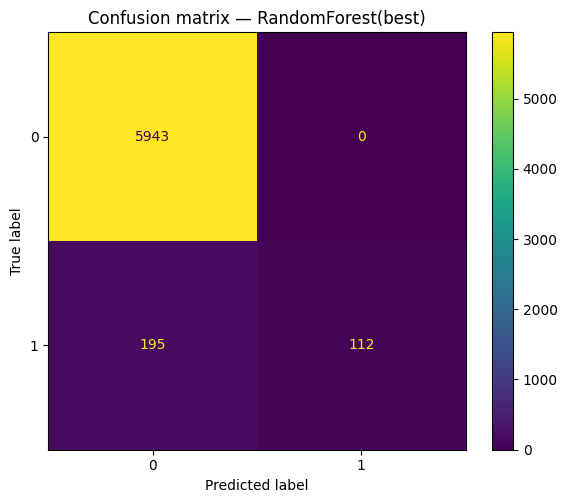

Saved: artifacts\figures\confusion_matrix__RandomForest_best_.png


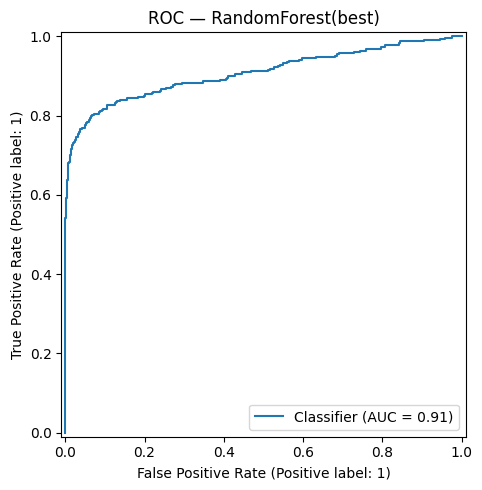

Saved: artifacts\figures\roc__RandomForest_best_.png


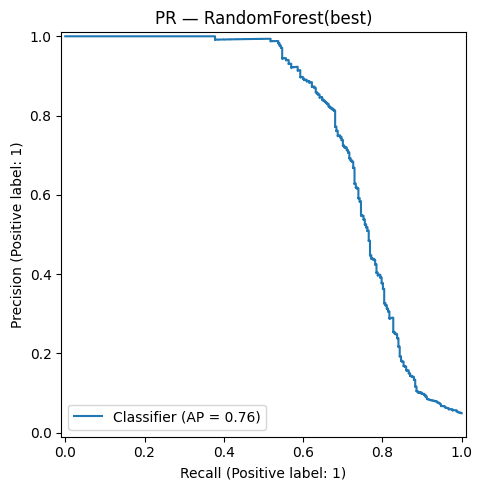

Saved: artifacts\figures\pr__RandomForest_best_.png


In [15]:
def safe_filename(s: str) -> str:
    return "".join(ch if ch.isalnum() or ch in ("-", "_") else "_" for ch in s)

name_slug = safe_filename(best_model_name)

# 1) Confusion matrix (всегда)
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax, values_format="d")
ax.set_title(f"Confusion matrix — {best_model_name}")
fig.tight_layout()
cm_path = FIGURES_DIR / f"confusion_matrix__{name_slug}.png"
fig.savefig(cm_path, dpi=150)
plt.show()
print("Saved:", cm_path)

# 2) ROC / PR — если бинарная и есть predict_proba
proba = safe_predict_proba(best_model, X_test)
if proba is not None and is_binary_task(y_test):
    y_score = proba[:, 1]

    fig, ax = plt.subplots(figsize=(6, 5))
    RocCurveDisplay.from_predictions(y_test, y_score, ax=ax)
    ax.set_title(f"ROC — {best_model_name}")
    fig.tight_layout()
    roc_path = FIGURES_DIR / f"roc__{name_slug}.png"
    fig.savefig(roc_path, dpi=150)
    plt.show()
    print("Saved:", roc_path)

    fig, ax = plt.subplots(figsize=(6, 5))
    PrecisionRecallDisplay.from_predictions(y_test, y_score, ax=ax)
    ax.set_title(f"PR — {best_model_name}")
    fig.tight_layout()
    pr_path = FIGURES_DIR / f"pr__{name_slug}.png"
    fig.savefig(pr_path, dpi=150)
    plt.show()
    print("Saved:", pr_path)
else:
    print("ROC/PR пропущены (не бинарная задача или нет predict_proba).")

,feature,importance_mean,importance_std
53,f54,0.014363,0.001988
52,f53,0.012329,0.005022
12,f13,0.011179,0.003801
24,f25,0.011064,0.002081
32,f33,0.010731,0.003105
57,f58,0.010728,0.004489
40,f41,0.009757,0.002490
46,f47,0.009739,0.004182
3,f04,0.008422,0.002927
35,f36,0.007167,0.006138


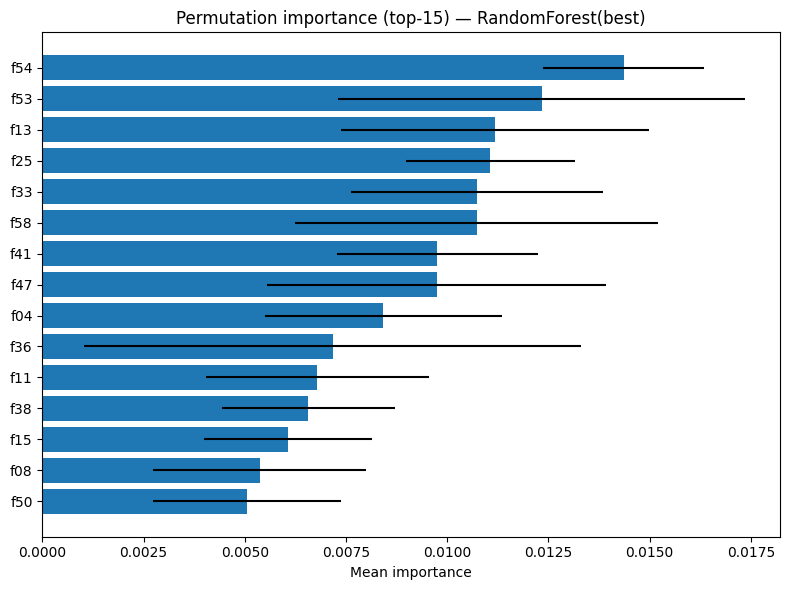

Saved: artifacts\figures\permutation_importance__RandomForest_best_.png


In [16]:
# scoring для permutation importance — тот же согласованный критерий
perm_scoring = "roc_auc" if is_binary_task(y_test) else "f1_macro"

result = permutation_importance(
    best_model,
    X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring=perm_scoring
)

# Имена признаков после препроцессинга (если есть OHE — появятся расширенные)
try:
    feature_names = best_model.named_steps["preprocess"].get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(len(result.importances_mean))])

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

top_n = 15
display(imp_df.head(top_n))

# График top-N
top = imp_df.head(top_n).iloc[::-1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
ax.set_title(f"Permutation importance (top-{top_n}) — {best_model_name}")
ax.set_xlabel("Mean importance")
fig.tight_layout()
imp_path = FIGURES_DIR / f"permutation_importance__{name_slug}.png"
fig.savefig(imp_path, dpi=150)
plt.show()
print("Saved:", imp_path)

In [18]:
from datetime import datetime, timezone

# 1) metrics_test.json
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, ensure_ascii=False, indent=2)

# (опционально удобно) metrics_test.csv
metrics_csv_path = ARTIFACTS_DIR / "metrics_test.csv"
metrics_df_sorted.to_csv(metrics_csv_path, index=True)

# 2) search_summaries.json (только для тех, где был подбор)
summaries_path = ARTIFACTS_DIR / "search_summaries.json"
with open(summaries_path, "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

# 3) best_model.joblib
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

# 4) best_model_meta.json
meta = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),  # Используем UTC
    "dataset_file": str(DATA_PATH),
    "best_model_name": best_model_name,
    "winner_metric": winner_metric,
    "best_model_test_metrics": metrics_test[best_model_name],
    "random_state": RANDOM_STATE,
    "test_size": TEST_SIZE,
    "label_encoder_classes": [str(x) for x in class_labels],
}

meta_path = ARTIFACTS_DIR / "best_model_meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved:", metrics_path)
print("Saved:", metrics_csv_path)
print("Saved:", summaries_path)
print("Saved:", model_path)
print("Saved:", meta_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\metrics_test.csv
Saved: artifacts\search_summaries.json
Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json


In [19]:
from copy import deepcopy

# Пример: 5 разных random_state для RandomForest(best) (быстро и показательно)
seeds = [0, 1, 2, 3, 4]
rows = []

# Возьмём лучший RF, если он есть
rf_key = "RandomForest(best)"
if rf_key in all_models:
    base_rf = all_models[rf_key]
    for seed in seeds:
        m = deepcopy(base_rf)
        # пробуем поменять random_state у внутренней модели
        try:
            m.named_steps["model"].set_params(random_state=seed)
        except Exception:
            pass
        m.fit(X_train, y_train)
        met = compute_metrics(m, X_test, y_test)
        met["seed"] = seed
        rows.append(met)

    stab_df = pd.DataFrame(rows)
    display(stab_df)
else:
    print("RandomForest(best) не найден — пропускаю.")

,accuracy,f1,roc_auc,average_precision,seed
0,0.96928,0.547170,0.901323,0.755735,0
1,0.96864,0.533333,0.899169,0.752924,1
2,0.96832,0.526316,0.902469,0.760140,2
3,0.96880,0.536817,0.897138,0.756786,3
4,0.96784,0.515663,0.903088,0.755658,4
